In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scvi

In [2]:
pbmc = sc.read_10x_mtx('/Users/gas361/Downloads/filtered_gene_bc_matrices/hg19/')
pbmc_10k = sc.read_10x_h5('../data/sc/10k_PBMC_3p_nextgem_Chromium_X_filtered_feature_bc_matrix.h5')
pbmc_10k.var_names_make_unique()
pbmc.layers['counts'] = pbmc.X.copy()
pbmc_10k.layers['counts'] = pbmc_10k.X.copy()


/Users/gas361/miniconda3/envs/sc_2024/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gas361/miniconda3/envs/sc_2024/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


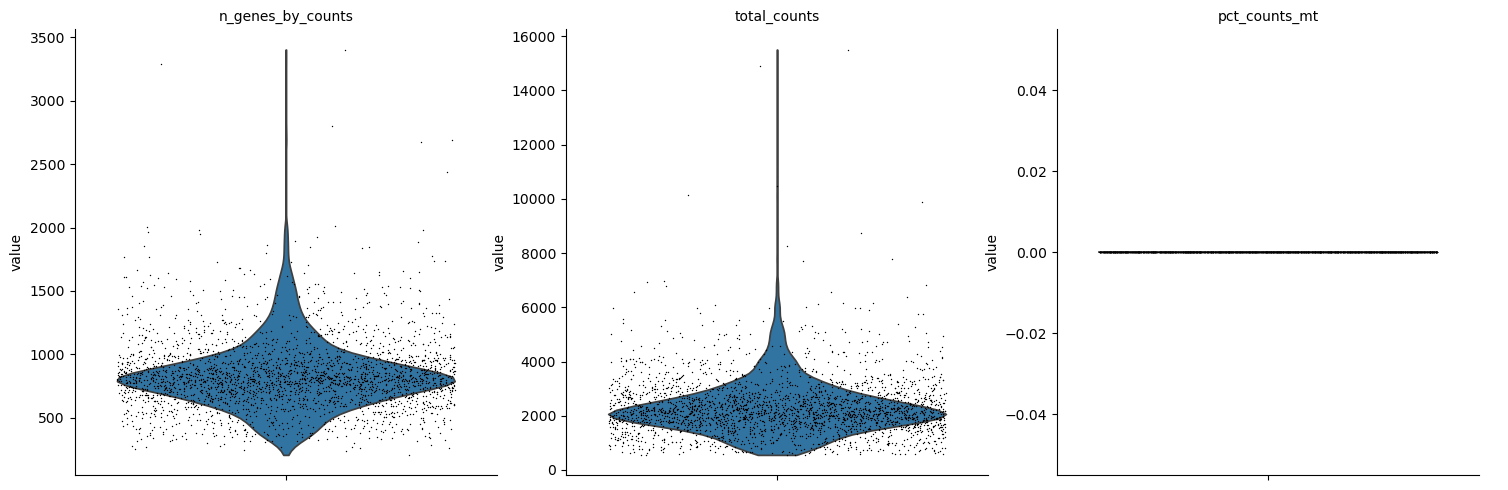

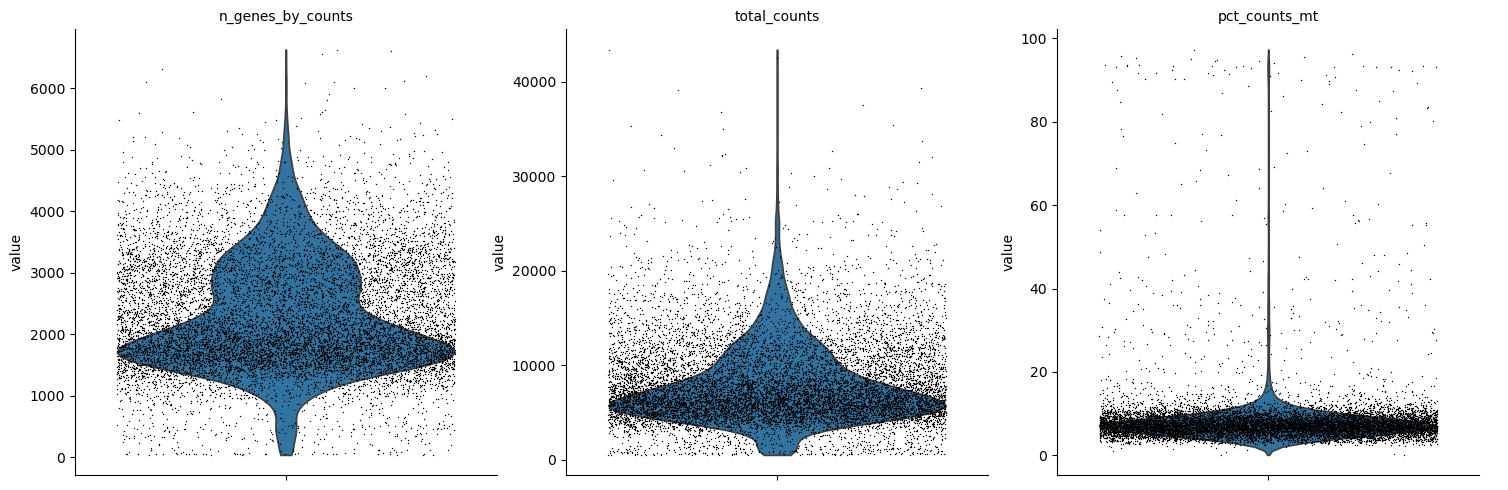

In [3]:
def qc(ad):
    ad.var['mt'] = ad.var.index.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    return ad
pbmc = qc(pbmc)
pbmc_10k = qc(pbmc_10k)

sc.pl.violin(
    pbmc,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.violin(
    pbmc_10k,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


{'n_genes_by_counts': [2723.409999999994, 214.801], 'total_counts': [10230.609999999982, 557.807], 'pct_counts_mt': [0.0, 0.0]}
{'n_genes_by_counts': [4389.300000000001, 574.4000000000001], 'total_counts': [19670.0, 1351.8], 'pct_counts_mt': [27.673744392395022, 3.4399818420410155]}


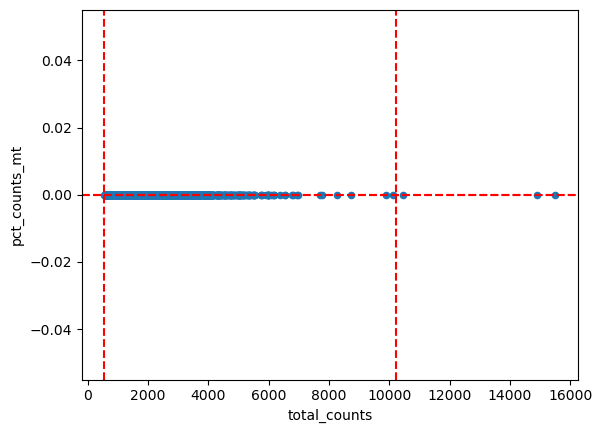

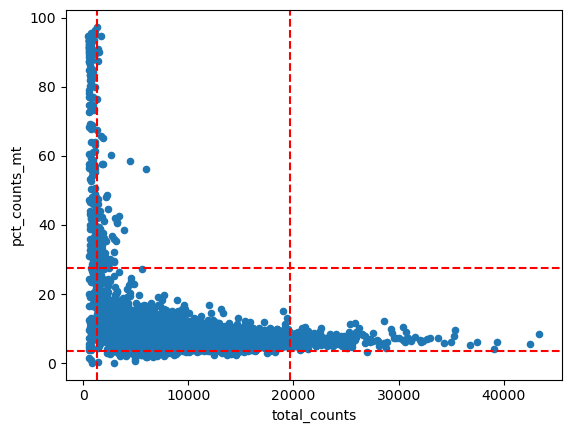

In [4]:
def dataset_qc_lim(ad,up=.98, down=.02):
    return {'n_genes_by_counts': [np.quantile(ad.obs.n_genes_by_counts.values, up),
                                  np.quantile(ad.obs.n_genes_by_counts.values, down)],
            'total_counts': [np.quantile(ad.obs.total_counts.values, up),
                             np.quantile(ad.obs.total_counts.values, down),],
            'pct_counts_mt': [np.quantile(ad.obs.pct_counts_mt.values, up),
                              np.quantile(ad.obs.pct_counts_mt.values, down)]
           }
    
pbmc_lim = dataset_qc_lim(pbmc,.999,.0001)
pbmc_10k_lim = dataset_qc_lim(pbmc_10k)

print(pbmc_lim)
print(pbmc_10k_lim)
pbmc.obs.plot(kind='scatter', x="total_counts", y="pct_counts_mt")
plt.axvline(pbmc_lim['total_counts'][0], color='r', linestyle='--')
plt.axvline(pbmc_lim['total_counts'][1], color='r', linestyle='--')
plt.axhline(pbmc_lim['pct_counts_mt'][0], color='r', linestyle='--')
plt.axhline(pbmc_lim['pct_counts_mt'][1], color='r', linestyle='--')
plt.show()

pbmc_10k.obs.plot(kind='scatter', x="total_counts", y="pct_counts_mt")
plt.axvline(pbmc_10k_lim['total_counts'][0], color='r', linestyle='--')
plt.axvline(pbmc_10k_lim['total_counts'][1], color='r', linestyle='--')
plt.axhline(pbmc_10k_lim['pct_counts_mt'][0], color='r', linestyle='--')
plt.axhline(pbmc_10k_lim['pct_counts_mt'][1], color='r', linestyle='--')
plt.show()


In [5]:
print(pbmc_10k.shape)
pbmc_10k = pbmc_10k[pbmc_10k.obs.pct_counts_mt.le(20) & pbmc_10k.obs.total_counts.le(30000)].copy()
sc.pp.filter_genes(pbmc_10k, min_cells=10)
print(pbmc_10k.shape)

print(pbmc.shape)
pbmc = pbmc[pbmc.obs.pct_counts_mt.le(10) & pbmc.obs.total_counts.le(8000)].copy()
sc.pp.filter_genes(pbmc, min_cells=10)
print(pbmc.shape)


(11996, 36601)
(11669, 18802)
(2691, 35635)
(2684, 11076)


In [6]:
pbmc.obs['batch'] = 'pbmc'
pbmc_10k.obs['batch'] = 'pbmc_10k'
combo = sc.concat([pbmc, pbmc_10k])

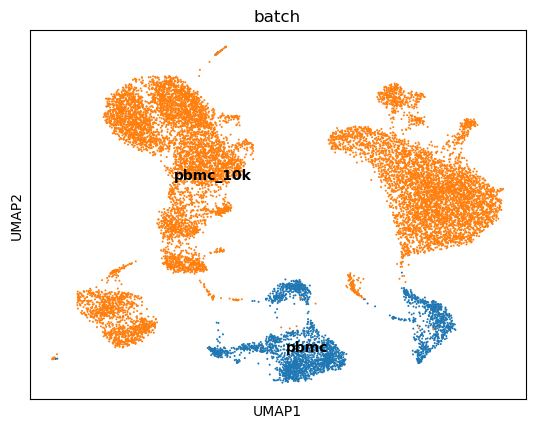

In [7]:
sc.pp.normalize_total(combo, target_sum=1e4)
sc.pp.log1p(combo)
sc.pp.scale(combo)
sc.pp.pca(combo)
sc.pp.neighbors(combo)
sc.tl.umap(combo)
sc.pl.umap(combo, color='batch', legend_loc='on data')

In [8]:
# %pip install harmonypy

2024-11-03 22:10:51,795 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-03 22:10:53,330 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-03 22:10:53,381 - harmonypy - INFO - Iteration 1 of 20
2024-11-03 22:10:54,781 - harmonypy - INFO - Iteration 2 of 20
2024-11-03 22:10:56,032 - harmonypy - INFO - Iteration 3 of 20
2024-11-03 22:10:57,485 - harmonypy - INFO - Iteration 4 of 20
2024-11-03 22:10:58,941 - harmonypy - INFO - Converged after 4 iterations


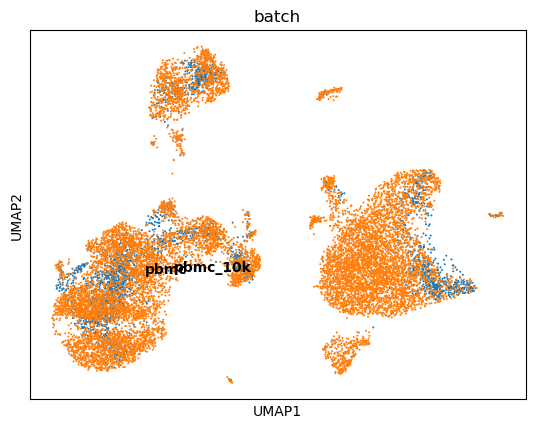

In [9]:
sce.pp.harmony_integrate(combo, 'batch', max_iter_harmony=20)
sc.pp.neighbors(combo, use_rep='X_pca_harmony')
sc.tl.umap(combo)
sc.pl.umap(combo, color='batch', legend_loc='on data')

/var/folders/2b/hn8_09990210yhfm3zc7p3jh0000gn/T/ipykernel_97699/1825662721.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combo, resolution=.3, key_added='undercluster')


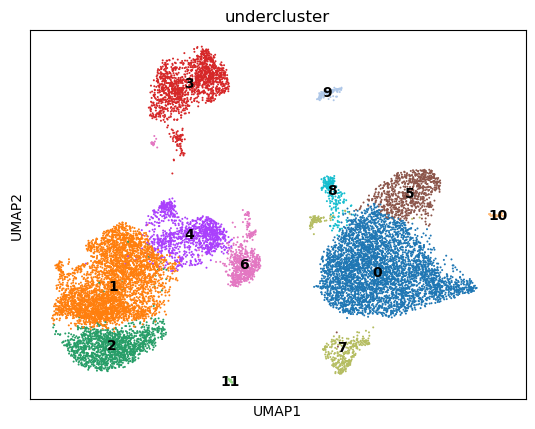

In [10]:
sc.tl.leiden(combo, resolution=.3, key_added='undercluster')
sc.pl.umap(combo, color='undercluster', legend_loc='on data')

In [11]:
combo.X = combo.layers['counts'].copy()
sc.pp.normalize_total(combo, target_sum=1e4)
sc.pp.log1p(combo)

sc.tl.rank_genes_groups(combo, 'undercluster')
markers = sc.get.rank_genes_groups_df(combo, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

group    names      scores  logfoldchanges     pvals  pvals_adj
0          0      LYZ  278.731384        6.685945  0.000000   0.000000
1          0   S100A9  231.682037        7.225525  0.000000   0.000000
2          0     FCN1  224.440674        5.516364  0.000000   0.000000
3          0   S100A8  207.136108        7.084648  0.000000   0.000000
4          0     CTSS  190.813522        4.626764  0.000000   0.000000
...      ...      ...         ...             ...       ...        ...
109826    11   PPHLN1    2.878536        1.151550  0.010888   0.049291
109827    11    ARMC8    2.878490        2.082251  0.010908   0.049361
109828    11   RAB27B    2.877229        3.955707  0.010942   0.049488
109829    11  RAPGEF2    2.875252        2.043561  0.010977   0.049604
109830    11    BAZ2B    2.874356        1.452073  0.010991   0.049643

[26027 rows x 6 columns]

In [12]:
marker_genes = {
    'T-cell': ['CD3D'],
    'CD4 T cells': ['IL7R'],
    'CD14+ Monocytes': ['CD14', 'LYZ'],
    'B cells': ['MS4A1','CD79A'],
    'CD8 T cells': ['CD8A','CD8B'],
    'NK cells': ['GNLY', 'NKG7'],
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
    'Dendritic Cells': ['FCER1A', 'CST3'],
    'Megakaryocytes': ['PPBP'],
    'Myeloid': ['CST3'],
}
marker_matches = sc.tl.marker_gene_overlap(combo, marker_genes)
marker_matches

0    1    2    3    4    5    6    7    8    9   10   11
T-cell             0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CD4 T cells        0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CD14+ Monocytes    2.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  1.0  0.0  0.0  0.0
B cells            0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CD8 T cells        0.0  0.0  2.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
NK cells           0.0  0.0  0.0  0.0  2.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0
FCGR3A+ Monocytes  0.0  0.0  0.0  0.0  0.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0
Dendritic Cells    1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  2.0  1.0  0.0  0.0
Megakaryocytes     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
Myeloid            1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0

In [13]:
# sc.pl.umap(adata, color = ['EPCAM', 'MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5)
top_markers = []
for x in markers.groupby('group', observed=True ):
    top_markers +=x[1].iloc[0:1].names.tolist()

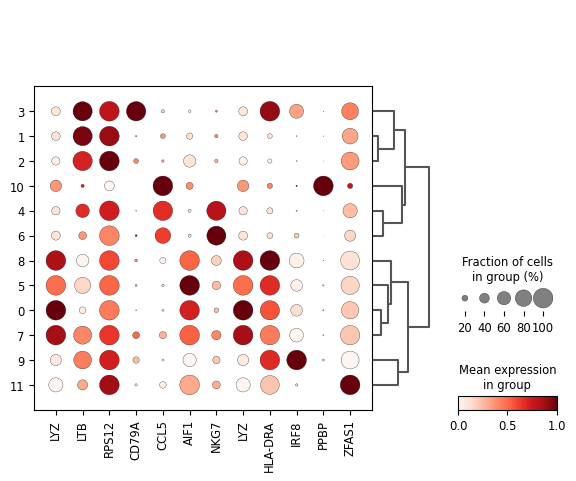

categories: 0, 1, 2, etc.
var_group_labels: T-cell, CD4 T cells, CD14+ Monocytes, etc.


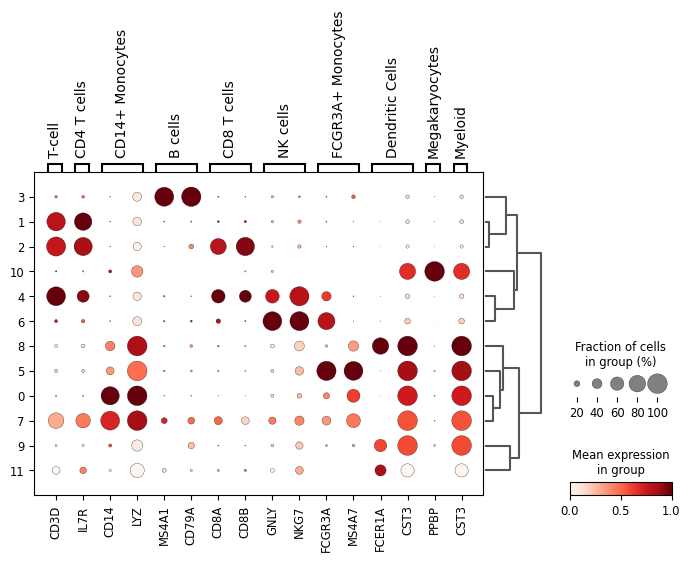

In [14]:
sc.tl.dendrogram(combo, 'undercluster')
sc.pl.dotplot(combo, top_markers , groupby='undercluster', dendrogram=True, mean_only_expressed=True, standard_scale='var')
sc.pl.dotplot(combo, marker_genes, groupby='undercluster', dendrogram=True, mean_only_expressed=True, standard_scale='var')

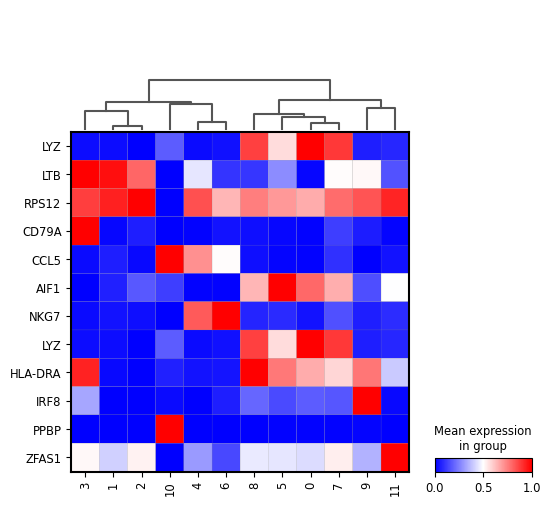

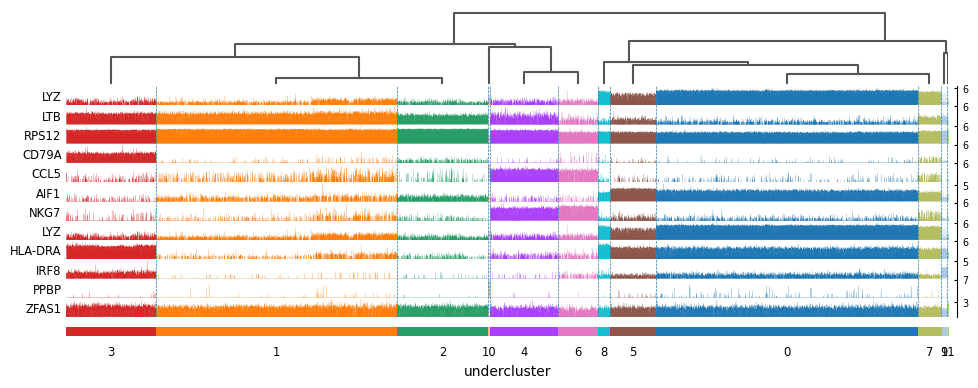

In [15]:
sc.pl.matrixplot(combo, top_markers ,
                 groupby='undercluster',
                 dendrogram=True, standard_scale='var',  cmap='bwr',swap_axes=True,
                )
sc.pl.tracksplot(combo, top_markers, groupby='undercluster', dendrogram=True)


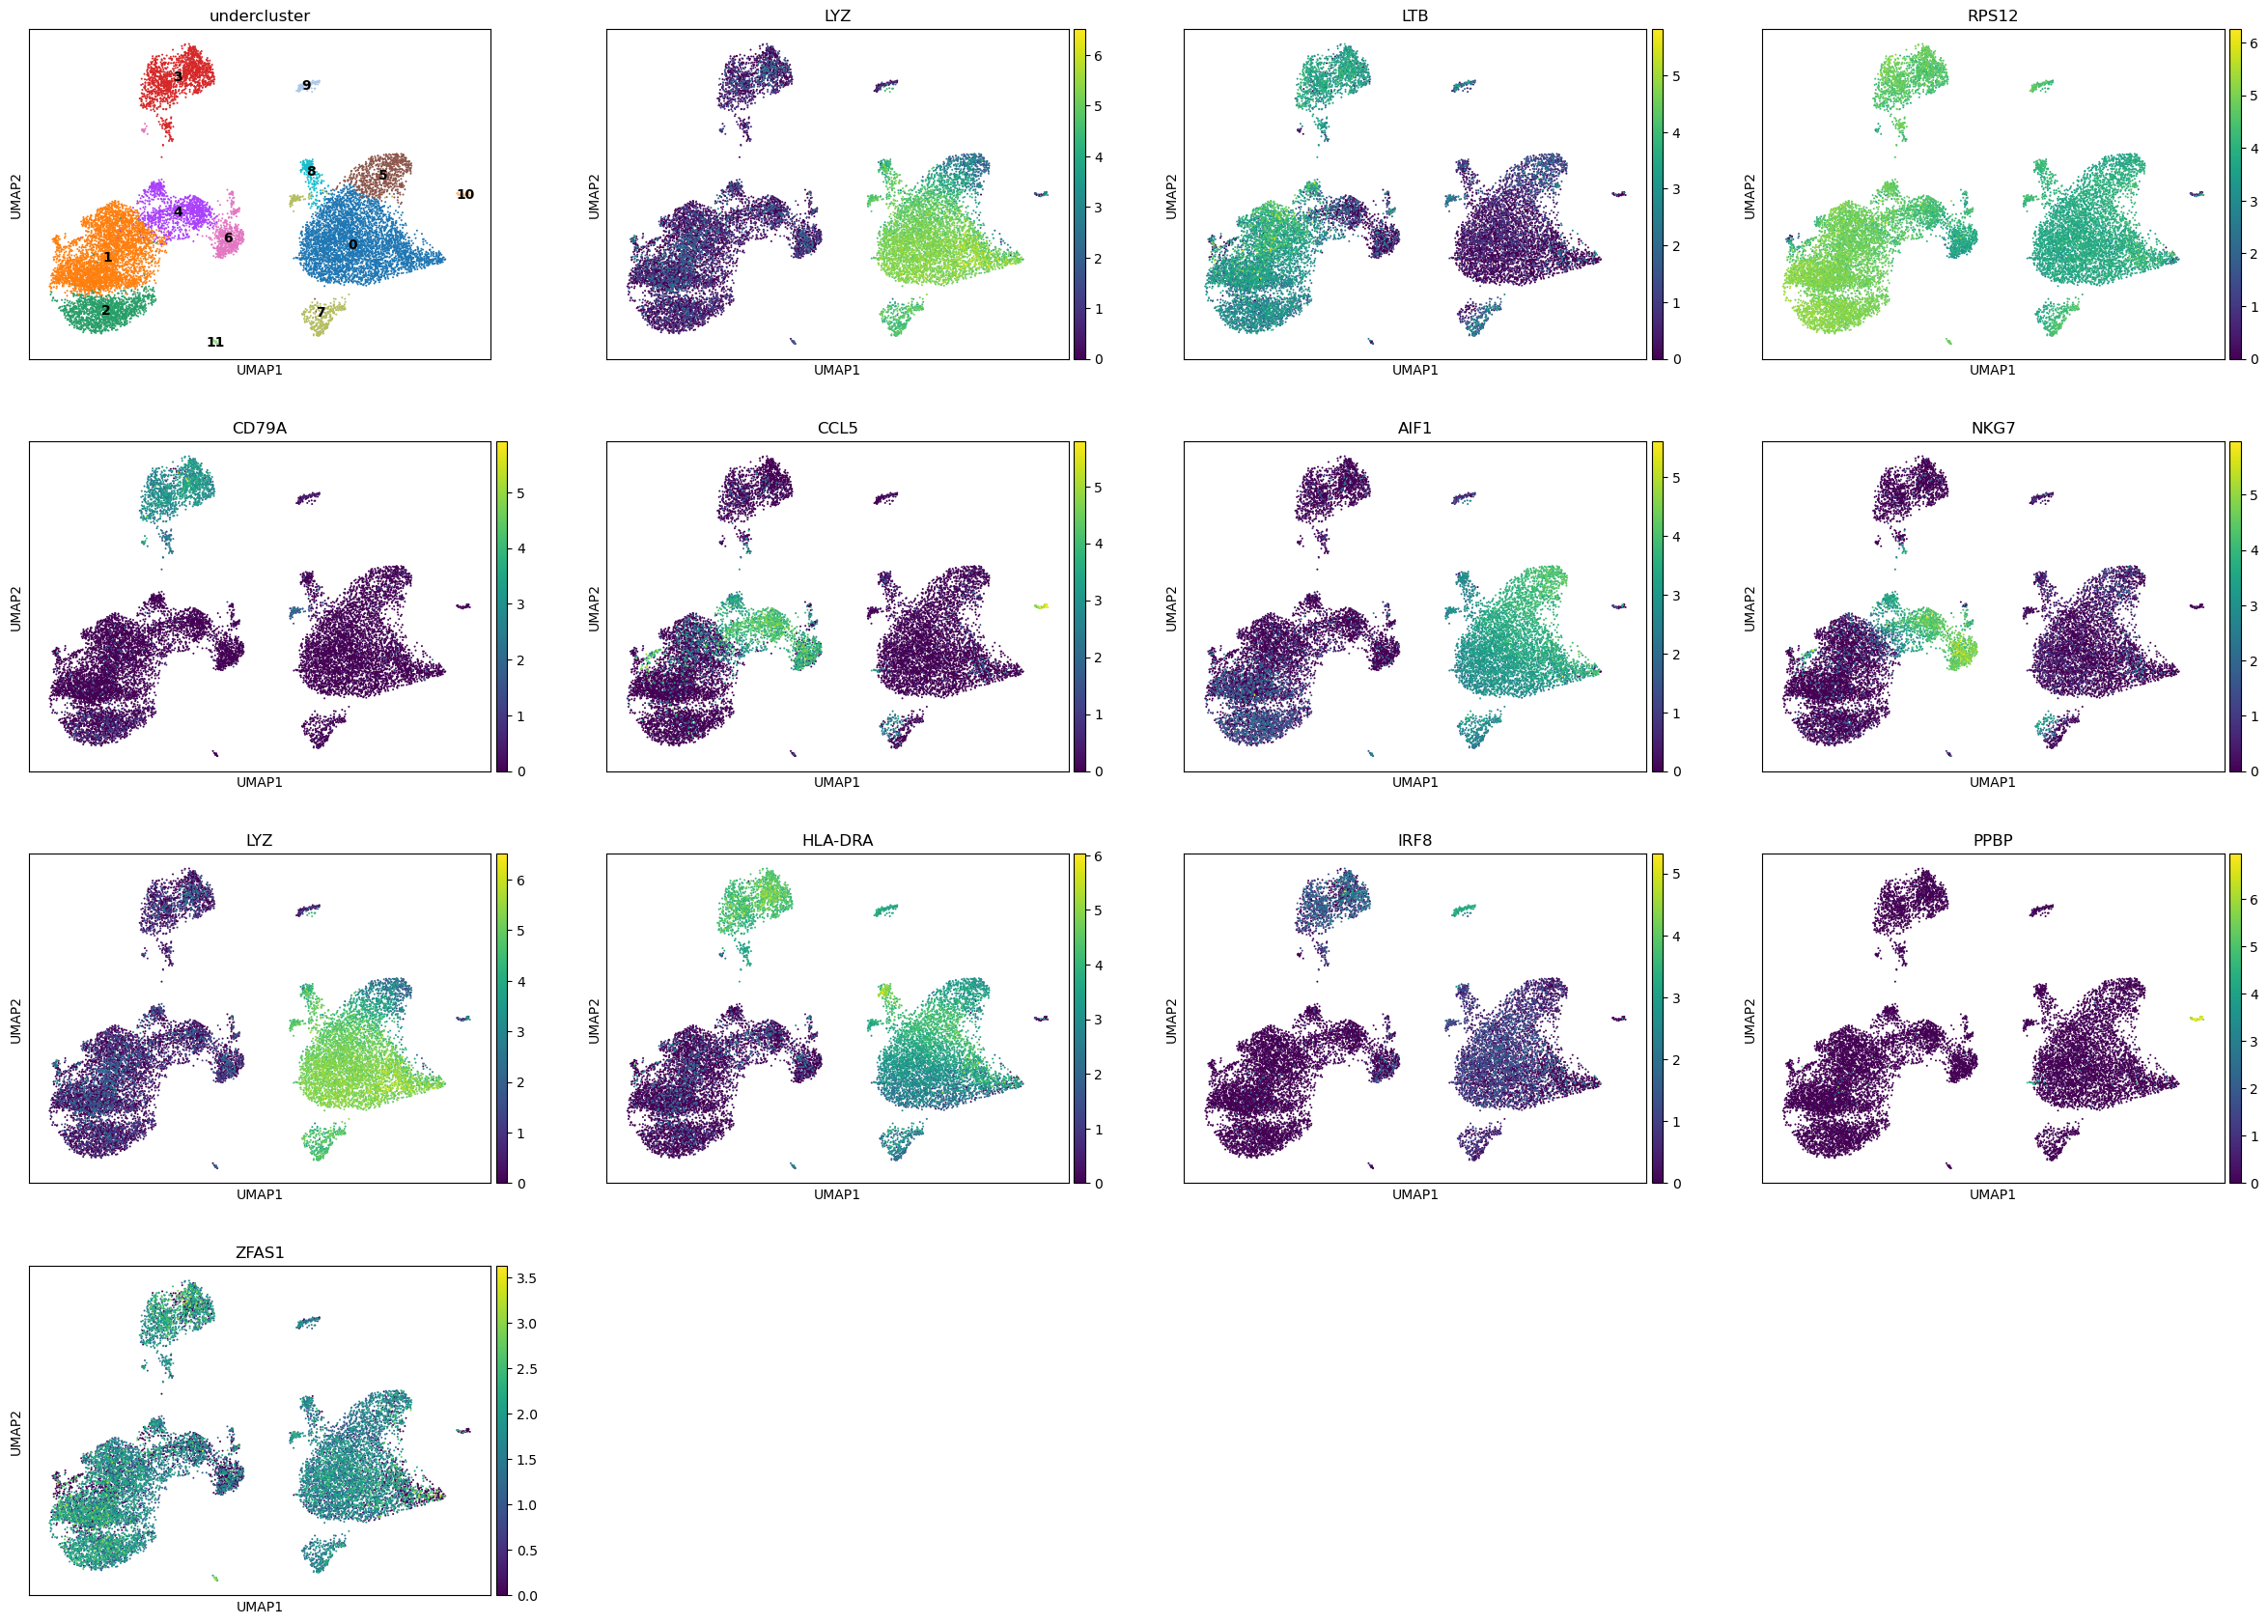

In [16]:
sc.pl.umap(combo, color=['undercluster']+top_markers, legend_loc='on data')

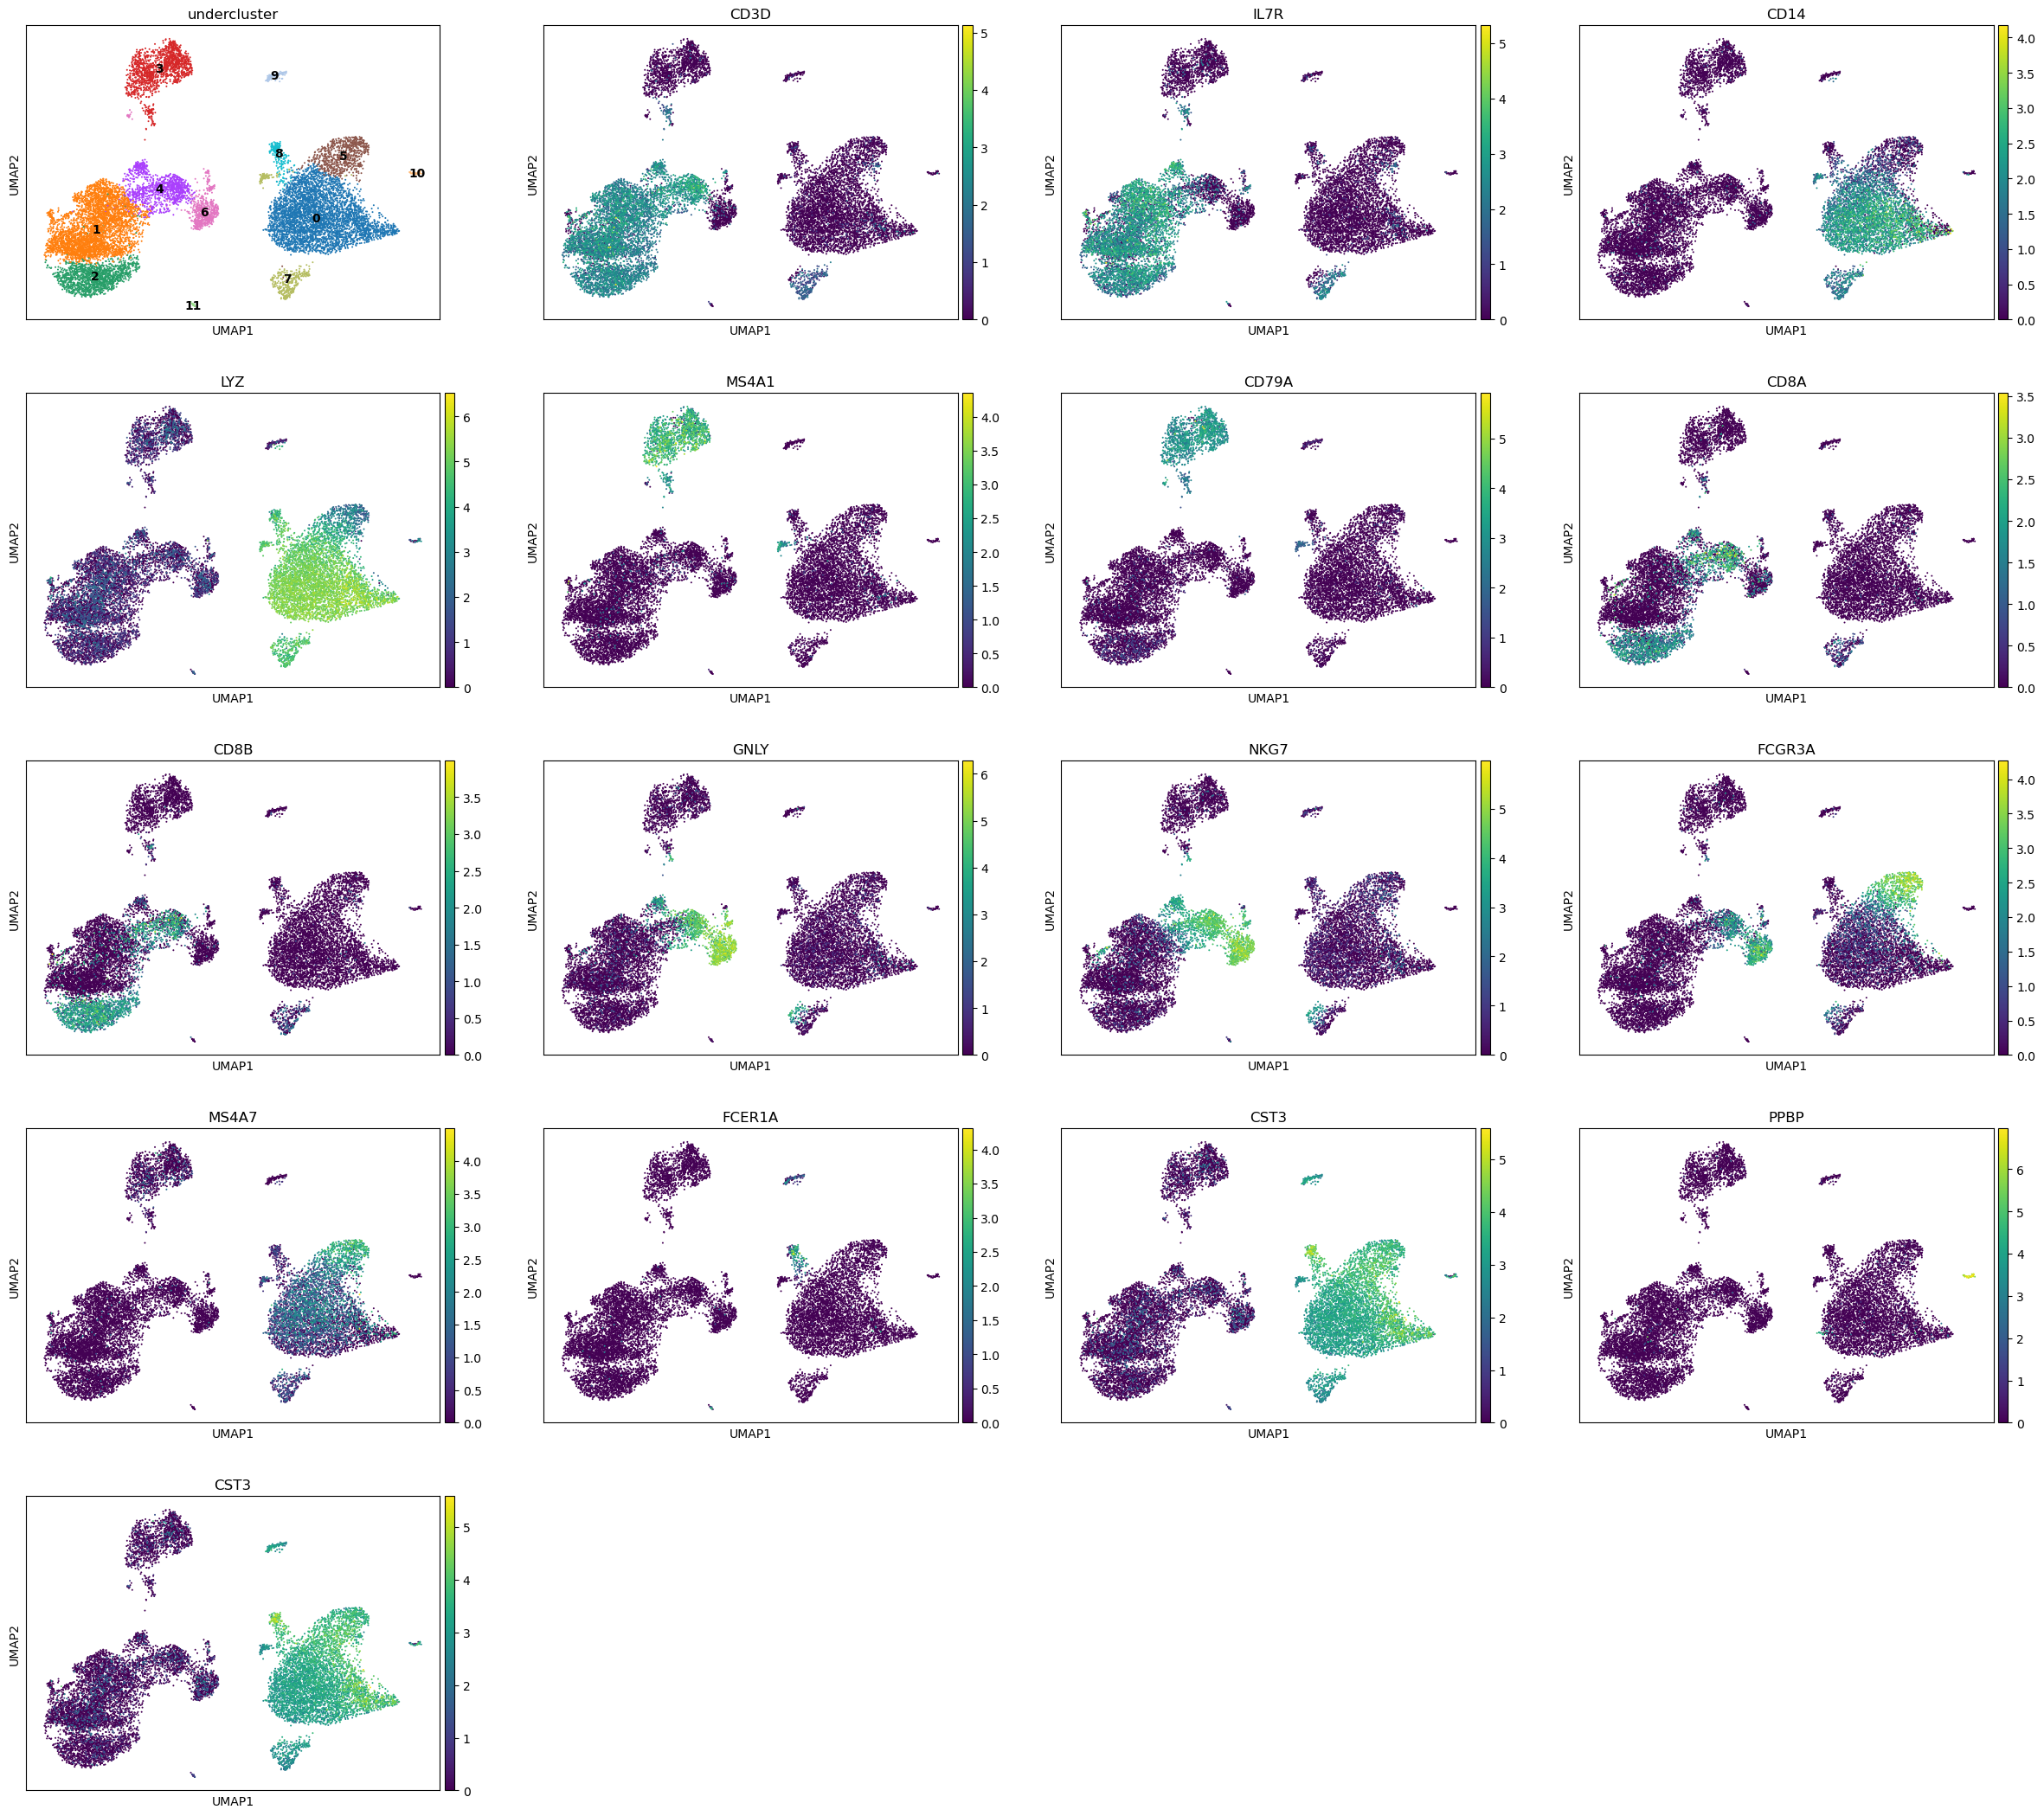

In [17]:
from itertools import chain
sc.pl.umap(combo, color=['undercluster']+list(chain.from_iterable([marker_genes[x] for x in marker_genes])), legend_loc='on data')